In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/projects/novel-translation


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/projects/novel-translation/.env.example


True

In [4]:
import os

results_path = os.getenv("RESULTS_PATH")
results_path

'results/mac-results.csv'

In [5]:
import pandas as pd
from datasets import load_dataset

print("loading result file")
datasets = load_dataset("csv", data_files={"results": results_path})
datasets

/Users/inflaton/anaconda3/envs/cs608/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading result file


Generating results split: 1133 examples [00:00, 66958.05 examples/s]


DatasetDict({
    results: Dataset({
        features: ['chinese', 'english', 'unsloth/Qwen2-0.5B-Instruct', 'unsloth/Qwen2-0.5B-Instruct(finetuned)', 'unsloth/Qwen2-1.5B-Instruct', 'unsloth/Qwen2-1.5B-Instruct(finetuned)', 'unsloth/Qwen2-7B-Instruct-bnb-4bit', 'unsloth/Qwen2-7B-Instruct-bnb-4bit(finetuned)', 'gradientai/Llama-3-8B-Instruct-Gradient-1048k', 'gradientai/Llama-3-8B-Instruct-Gradient-1048k(finetuned)'],
        num_rows: 1133
    })
})

In [6]:
df = datasets["results"].to_pandas()
df.head()

,chinese,english,unsloth/Qwen2-0.5B-Instruct,unsloth/Qwen2-0.5B-Instruct(finetuned),unsloth/Qwen2-1.5B-Instruct,unsloth/Qwen2-1.5B-Instruct(finetuned),unsloth/Qwen2-7B-Instruct-bnb-4bit,unsloth/Qwen2-7B-Instruct-bnb-4bit(finetuned),gradientai/Llama-3-8B-Instruct-Gradient-1048k,gradientai/Llama-3-8B-Instruct-Gradient-1048k(finetuned)
0,老耿端起枪，眯缝起一只三角眼，一搂扳机响了枪，冰雹般的金麻雀劈哩啪啦往下落，铁砂子在柳枝间飞...,"Old Geng picked up his shotgun, squinted, and ...","Old Tang held his gun, squinting his eyes with...",Old Geng lifted his rifle and narrowed his eye...,"Old Geng took up his gun, squinted one of its ...","Old Geng raised the rifle, squeezed one tiny t...","Old Geng raised his gun, squinting one of his ...",Old Geng raised his rifle and squinted into on...,"Old Geng raised his gun, squinted through one ...","Old Geng raised his rifle, squinted through on..."
1,次日天未明时，刘老老便起来梳洗了， 又将板儿教了几句话； 五六岁的孩子，听见带了他进城逛去，...,Next day Grannie Liu was up before dawn. As so...,"The next morning when it was still dark, Liu G...",It was still not light when this little update...,"By the time the next day dawned, Liu Lao got u...","Having been woken just before daybreak, Granni...","The next morning, before dawn, Old Liu rose to...",First thing next morning Grannie Liu rose earl...,"The next day, when it was still dark, Liu Lao ...",Next morning before daybreak Liu Old colouring...
2,钱老板道：“是，是，多谢香主。” 在一张椅上坐了，续道：“属下将小郡主藏在猪肚里带进宫来，一...,"'Thank you, Master,' said Butcher Qian, seatin...","Qian Shou said, “Yes, yes, thank you very much...","Yes, sir,' said Butcher Qian and sat down at t...","Mr. Qian said, ""Yes, yes, thank you very much....","Please, Master, thank you,' said the butcher. ...","Money Master said, ""Yes, yes, thank you for yo...","Yes, Goong-goong, ' said Butcher Qian, and sat...","The money boss said: ""Is that so? Thank you, m...","'Of course,' said Butcher Qian, sitting himsel..."
3,但已经晚了，物理学家静静地躺在地上，半睁的双眼看着从他的头颅上流出的血迹，疯狂的会场瞬间陷入...,But it was already too late. The physicist lay...,But it was too late; the physicist lay still o...,But already then he was too late. The physical...,But it was too late. Physicists lay quietly on...,It was too late. The physics professor lay on ...,But it was too late. The physicist lay quietly...,But it was too late. The physicist lay on the ...,But it was already too late. The physicist lay...,But it was too late. The physicist lay quietly...
4,但这时，绍琳却做出了一件出人意料的事，与一位受迫害的教育部高干结了婚，当时那名高干还在干校住...,But then Shao did something that no one expect...,"But then, Song Lin made a surprising move by m...",But just then Shao Lin made a surprising turn....,"But at this time, Su Ling made a surprising mo...","But suddenly, Shao Lin made a decision that we...","But at this point, Shao Lin did something unex...",But then Shao Lin unexpectedly did something n...,"However, Shao Lin did something unexpected at ...","However, this was not at all what anyone expec..."


In [7]:
metrics_df = pd.DataFrame(df.columns.T)[2:]
# metrics_df.reset_index(inplace=True)
metrics_df

,0
2,unsloth/Qwen2-0.5B-Instruct
3,unsloth/Qwen2-0.5B-Instruct(finetuned)
4,unsloth/Qwen2-1.5B-Instruct
5,unsloth/Qwen2-1.5B-Instruct(finetuned)
6,unsloth/Qwen2-7B-Instruct-bnb-4bit
7,unsloth/Qwen2-7B-Instruct-bnb-4bit(finetuned)
8,gradientai/Llama-3-8B-Instruct-Gradient-1048k
9,gradientai/Llama-3-8B-Instruct-Gradient-1048k(...


In [8]:
metrics_df.rename(columns={0: "model"}, inplace=True)
metrics_df.reset_index(inplace=True)
metrics_df = metrics_df.drop(columns=["index"])
metrics_df

,model
0,unsloth/Qwen2-0.5B-Instruct
1,unsloth/Qwen2-0.5B-Instruct(finetuned)
2,unsloth/Qwen2-1.5B-Instruct
3,unsloth/Qwen2-1.5B-Instruct(finetuned)
4,unsloth/Qwen2-7B-Instruct-bnb-4bit
5,unsloth/Qwen2-7B-Instruct-bnb-4bit(finetuned)
6,gradientai/Llama-3-8B-Instruct-Gradient-1048k
7,gradientai/Llama-3-8B-Instruct-Gradient-1048k(...


In [9]:
from translation_utils import *

accuracy = []
meteor = []
bleu_1 = []
rouge_l = []
all_metrics = []
for col in df.columns[2:]:
    metrics = calc_metrics(df["english"], df[col], debug=True)
    print(f"{col}: {metrics}")
    
    accuracy.append(metrics["accuracy"])
    meteor.append(metrics["meteor"])
    bleu_1.append(metrics["bleu_scores"]["bleu"])
    rouge_l.append(metrics["rouge_scores"]["rougeL"])
    all_metrics.append(metrics)

metrics_df["accuracy"] = accuracy
metrics_df["meteor"] = meteor
metrics_df["bleu_1"] = bleu_1
metrics_df["rouge_l"] = rouge_l
metrics_df["all_metrics"] = all_metrics

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/inflaton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


unsloth/Qwen2-0.5B-Instruct: {'accuracy': 0.0, 'correct_ids': [], 'meteor': 0.26682092609395136, 'bleu_scores': {'bleu': 0.050004191193532964, 'precisions': [0.32555012625848556, 0.07871253405994551, 0.025538396146217057, 0.009553670232386574], 'brevity_penalty': 1.0, 'length_ratio': 1.010036435905929, 'translation_length': 30493, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.32043146784739074, 'rouge2': 0.09505755699773469, 'rougeL': 0.264260070381761, 'rougeLsum': 0.26426082152437436}}
unsloth/Qwen2-0.5B-Instruct(finetuned): {'accuracy': 0.00088261253309797, 'correct_ids': [147], 'meteor': 0.29032409482315213, 'bleu_scores': {'bleu': 0.06508609399238363, 'precisions': [0.3407579117113485, 0.09377291935878182, 0.03598822203642444, 0.01652015762352228], 'brevity_penalty': 0.9858565320713017, 'length_ratio': 0.9859556144418682, 'translation_length': 29766, 'reference_length': 30190}, 'rouge_scores': {'rouge1': 0.32318929808181796, 'rouge2': 0.1124563282079071, 'rougeL': 0.267

In [10]:
metrics_df.describe()

,accuracy,meteor,bleu_1,rouge_l
count,8.000000,8.000000,8.000000,8.000000
mean,0.003310,0.342265,0.092537,0.325713
std,0.003825,0.048720,0.028926,0.043398
min,0.000000,0.266821,0.050004,0.264260
25%,0.000662,0.312307,0.075027,0.303595
50%,0.002207,0.345280,0.090101,0.325757
75%,0.004192,0.377166,0.112667,0.360207
max,0.009709,0.406582,0.135494,0.381732


In [11]:
metrics_df

,model,accuracy,meteor,bleu_1,rouge_l,all_metrics
0,unsloth/Qwen2-0.5B-Instruct,0.000000,0.266821,0.050004,0.264260,"{'accuracy': 0.0, 'correct_ids': [], 'meteor':..."
1,unsloth/Qwen2-0.5B-Instruct(finetuned),0.000883,0.290324,0.065086,0.267450,"{'accuracy': 0.00088261253309797, 'correct_ids..."
2,unsloth/Qwen2-1.5B-Instruct,0.001765,0.335521,0.082854,0.328452,"{'accuracy': 0.00176522506619594, 'correct_ids..."
3,unsloth/Qwen2-1.5B-Instruct(finetuned),0.002648,0.355038,0.097349,0.323063,"{'accuracy': 0.00264783759929391, 'correct_ids..."
4,unsloth/Qwen2-7B-Instruct-bnb-4bit,0.002648,0.372233,0.109749,0.357861,"{'accuracy': 0.00264783759929391, 'correct_ids..."
5,unsloth/Qwen2-7B-Instruct-bnb-4bit(finetuned),0.008826,0.406582,0.135494,0.381732,"{'accuracy': 0.0088261253309797, 'correct_ids'..."
6,gradientai/Llama-3-8B-Instruct-Gradient-1048k,0.000000,0.319634,0.078340,0.315644,"{'accuracy': 0.0, 'correct_ids': [], 'meteor':..."
7,gradientai/Llama-3-8B-Instruct-Gradient-1048k(...,0.009709,0.391966,0.121423,0.367245,"{'accuracy': 0.009708737864077669, 'correct_id..."


/var/folders/7x/56svhln929zdh2xhr3mwqg4r0000gn/T/ipykernel_37116/1457736925.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(["METEOR", "BLEU-1", "ROUGE-L"])


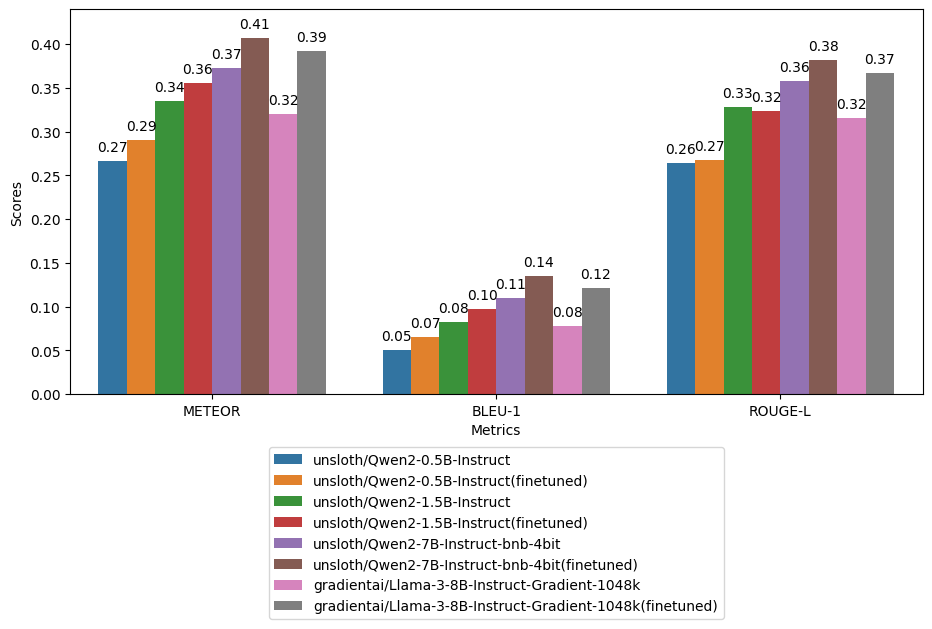

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 5))

# Assuming `df` is your DataFrame and 'model', 'accuracy', 'meteor', 'bleu_1', 'rouge_l' are columns in `df`
df_melted = pd.melt(
    metrics_df, id_vars="model", value_vars=["meteor", "bleu_1", "rouge_l"]
)

barplot = sns.barplot(x="variable", y="value", hue="model", data=df_melted)
barplot.set_xticklabels(["METEOR", "BLEU-1", "ROUGE-L"])

# show numbers on the bars
for p in barplot.patches:
    if p.get_height() == 0:
        continue
    
    barplot.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

# set ylimit
barplot.set(ylim=(0, 0.44), ylabel="Scores", xlabel="Metrics")

# Move the legend to an empty part of the plot
plt.legend(bbox_to_anchor=(0.5, -0.12), loc="upper center")
# plt.tight_layout()

plt.show()